Get fiducial w, cs2, etc.

In [46]:
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import matplotlib as mpl

In [47]:
"""Settings and Parameters"""

# Plot Settings
plot_params = {'legend.fontsize': 'x-large',
               'figure.figsize': (13, 7),
               'axes.labelsize': 'x-large',
               'axes.titlesize':'x-large',
               'xtick.labelsize':'x-large',
               'ytick.labelsize':'x-large',
               'font.family' :'serif',
               'font.sans-serif' :'Garamond'}
plt.rcParams.update(plot_params)


# Parameters
h = 0.05
H0 = 67.
Ωb0 = 0.04968
Ωc0 = 0.26754
Ωɣ0 = 5.50234e-5
Ων0 = 3.74248e-5

Ωr0 = Ωɣ0 + Ων0
Ωm0 = Ωb0 + Ωc0
ΩΛ  = 1-(Ωb0 + Ωc0 + Ωɣ0)


z_rec = 1090
a_rec = 1/(1+z_rec)
a_eq  = Ωr0/Ωm0

# Numerical Settings
τ0 = .001 / (H0 * 1000)

k_low = .0001 *H0*1000
k_high= 2.0  *H0*1000

N = 100
K = 100

In [48]:
"""Background Cosmology"""

def tau_itgd(a):
    """conformal time integrand"""
    return  1/(a**2* H0 * np.sqrt(Ωm0*a**-3 + Ωr0*a**-4 + ΩΛ))

(τ_rec,_) = integrate.quad(tau_itgd,0,a_rec)
(τ_eq,_) = integrate.quad(tau_itgd,0,a_eq)
(τ_now,_) = integrate.quad(tau_itgd,0,1)
τr = 1/(np.sqrt(Ωm0/a_rec)*H0/2)


α = np.sqrt(a_rec/a_eq)
a = lambda τ: a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
y = lambda τ: a(τ)/a_eq
ℋ = lambda τ: 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
yb = lambda τ: 1.68*y(τ)*Ωb0/Ωm0

Ωb = lambda τ: Ωb0 * a(τ)**-3.
Ωc = lambda τ: Ωc0 * a(τ)**-3.
Ωɣ = lambda τ: Ωɣ0 * a(τ)**-4.
Ων = lambda τ: Ων0 * a(τ)**-4.
Ωm = lambda τ: Ωm0 * a(τ)**-3.
Ωr = lambda τ: Ωr0 * a(τ)**-4.
ΩT = lambda τ: Ωm(τ) + Ωr(τ)
Ωd = lambda τ: Ωc(τ) + Ων(τ)

In [49]:
"""3-Fluid Mode Evolution"""

# initialize arrays
τ = np.linspace(τ0, τ_rec , N)
k_list = np.geomspace(k_low, k_high, K)
k_list = np.linspace(k_low, k_high, K)
Φ = np.zeros((K,N))
δɣ = np.zeros((K,N))
vɣ = np.zeros((K,N))
δc = np.zeros((K,N))
vc = np.zeros((K,N))
δν = np.zeros((K,N))
vν = np.zeros((K,N))


for i, k in enumerate(k_list):
    
    # set initial conditions
    Φ0  = 1.0
    δɣ0 = -2*Φ0*(1 + 3*y(τ0)/16)
    vɣ0 = -k/(ℋ(τ0)) * (δɣ0/4 + (2*k**2 * (1 + y(τ0))*Φ0)/
                        (9*(ℋ(τ0))**2 * (4./3. +y(τ0))))
    δc0 = .75 * δɣ0
    vc0 = vɣ0
    δν0 = δɣ0
    vν0 = vɣ0
    
    # solve the ODE
    def DY(τ, Y):
        [Φ, δɣ, vɣ, δc, vc, δν, vν] = Y
        
        DΦ  = -ℋ(τ)*Φ + (3/2.*H0**2.*a(τ)**2/k)*\
        (4./3.*(Ωɣ(τ)*vɣ + Ων(τ)*vν) + Ωc(τ)*vc + Ωb(τ)*vɣ)
        
        Dδɣ = -4./3.*k*vɣ + 4*DΦ
        Dvɣ = (-ℋ(τ)*yb(τ)*vɣ + k*δɣ/3)/(
            4./3. + yb(τ)) + k*Φ
        
        Dδc = -k*vc + 3*DΦ
        Dvc = -ℋ(τ)*vc + k*Φ
        
        Dδν = -4./3.*k*vν + 4*DΦ
        Dvν = k*δν/4 + k*Φ
        
        return [DΦ, Dδɣ, Dvɣ, Dδc, Dvc, Dδν, Dvν]
    Y0 = [Φ0, δɣ0, vɣ0, δc0, vc0, δν0, vν0]
    out = integrate.solve_ivp(DY, [τ0, τ_rec], Y0,
                              method='RK45', max_step=τ_rec/N)
    sol = out['y']
    
    Φ[i,:]  = np.interp(τ, out['t'],sol[0])
    δɣ[i,:] = np.interp(τ, out['t'],sol[1])
    vɣ[i,:] = np.interp(τ, out['t'],sol[2])
    δc[i,:] = np.interp(τ, out['t'],sol[3])
    vc[i,:] = np.interp(τ, out['t'],sol[4])
    δν[i,:] = np.interp(τ, out['t'],sol[5])
    vν[i,:] = np.interp(τ, out['t'],sol[6])

Φ_  = interp1d(τ,Φ,fill_value="extrapolate")
δɣ_ = interp1d(τ,δɣ,fill_value="extrapolate")
vɣ_ = interp1d(τ,vɣ,fill_value="extrapolate")
δc_ = interp1d(τ,δc,fill_value="extrapolate")
vc_ = interp1d(τ,vc,fill_value="extrapolate")
δν_ = interp1d(τ,δν,fill_value="extrapolate")
vν_ = interp1d(τ,vν,fill_value="extrapolate")

In [50]:
"""Extract GDM functions"""

wd = Ων(τ)/(3*Ωd(τ))
Dwd = np.gradient(wd,τ)
δd = (Ωc(τ)*δc + Ων(τ)*δν)/Ωd(τ)
vd = (Ωc(τ)*vc + 4/3*Ων(τ)*vν)/((1+wd)*Ωd(τ))
cs2d =(δν*Ων(τ)*1/3)/(δd*Ωd(τ)) 

δd3 = (Ωc(τ)*δc + Ων(τ)*δν)/Ωd(τ)
vd3 = (Ωc(τ)*vc + 4/3*Ων(τ)*vν)/((1+wd)*Ωd(τ))
Φ3 = copy.deepcopy(Φ)

δd_ = interp1d(τ,δd, fill_value="extrapolate")
vd_ = interp1d(τ,vd, fill_value="extrapolate")
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

In [51]:
pickle.dump(τ, open( "data/tau_vals.p", "wb" ) )
pickle.dump(k_list, open( "data/k_vals.p", "wb" ) )

pickle.dump(wd, open( "data/w_d.p", "wb" ) )
pickle.dump(cs2d, open( "data/cs2_d.p", "wb" ) )

pickle.dump(δd_(τ[0]), open( "data/delta_d_init.p", "wb" ) )
pickle.dump(vd_(τ[0]), open( "data/v_d_init.p", "wb" ) )
pickle.dump(δɣ_(τ[0]), open( "data/delta_g_init.p", "wb" ) )
pickle.dump(vɣ_(τ[0]), open( "data/v_g_init.p", "wb" ) )
pickle.dump(Φ_(τ[0]), open( "data/phi_init.p", "wb" ) )

In [52]:
"""1-fluid mode evolution"""

# Initialize arrays:


SW = np.zeros(K)
DOP = np.zeros(K)


Φ1 = np.zeros((K,N))
δd = np.zeros((K,N))
vd = np.zeros((K,N))

for i, k in enumerate(k_list):
    
    # set initial conditions
    Φ0  = Φ_(τ0)[i]
    δɣ0 = δɣ_(τ0)[i]
    vɣ0 = vɣ_(τ0)[i]
    δd0 = δd_(τ0)[i]
    vd0 = vd_(τ0)[i]
    
    # solve the ODE
    def DY(τ, Y):
        [Φ, δɣ, vɣ, δd, vd] = Y
        (wd, Dwd, cs2d) = (wd_(τ), Dwd_(τ), cs2d_(τ)[i])
        
        f = vd*Ωd(τ)*(1+wd) + 4./3.*Ωɣ(τ)*vɣ +  Ωb(τ)*vɣ
        
        DΦ  = -ℋ(τ)*Φ + (3/2.*H0**2.*a(τ)**2/k)*f
        
        Dδɣ = -4./3.*k*vɣ + 4*DΦ
        Dvɣ = (-ℋ(τ)*yb(τ)*vɣ + k*δɣ/3)/(
            4./3. + yb(τ)) + k*Φ
        
        Dδd = -(1+wd)*(k*vd-3*DΦ) - 3*ℋ(τ)*(cs2d-wd)*δd
        Dvd = -ℋ(τ)*(1-3*wd)*vd - vd*Dwd/(1+wd) + k*δd*cs2d/(1+wd) + k*Φ
        
        return [DΦ, Dδɣ, Dvɣ, Dδd, Dvd]
    
    Y0 = [Φ0, δɣ0, vɣ0, δd0, vd0]

    [Φ_rec, δɣ_rec, vɣ_rec, δd_rec, vd_rec]= integrate.solve_ivp(
        DY, [τ0, τ_rec], Y0,method='RK45',t_eval=[τ_rec])['y'][:,0]
    
    # Collect Source Terms:
    SW[i] = Φ_rec + δɣ_rec/4
    DOP[i] = vɣ_rec

#add silk damping
k = k_list
τs = 0.6*Ωm0**(.25) * Ωb0**(-.5)*a_rec**(.75)*(H0/100)**(-.5)*τr
SWsd = SW*np.exp(-(k*τs)**2)
DOPsd = DOP*np.exp(-(k*τs)**2)
SW_ = interp1d(k, SW, fill_value="extrapolate")
DOP_ = interp1d(k, DOP, fill_value="extrapolate")
SWsd_ = interp1d(k, SWsd, fill_value="extrapolate")
DOPsd_ = interp1d(k, DOPsd, fill_value="extrapolate")



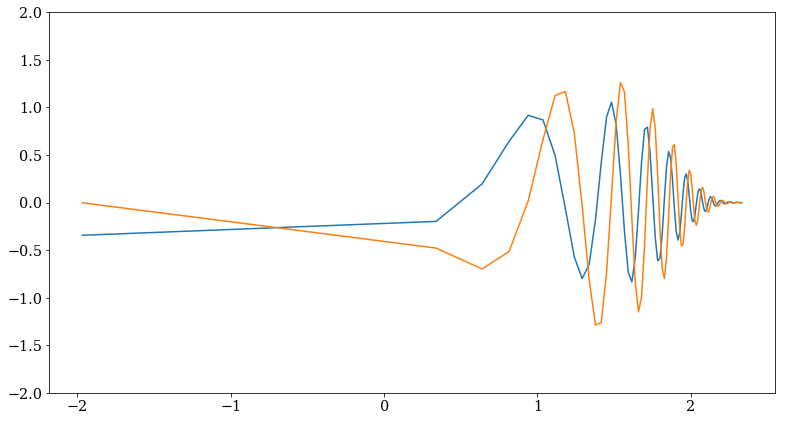

In [53]:
plt.plot(np.log10(k*τr), -SWsd)
plt.plot(np.log10(k*τr), -DOPsd)
plt.ylim(-2,2)
im = plt.imread('img/seljak_1.png')
#implot = plt.imshow(im, extent=[-1,2.2,-1.5,1.5],aspect='auto',zorder=0)
plt.show()



In [54]:
"""Precompute Bessel Functions"""

l_low = 2
l_high = 1200

l_list = np.array([2,3,4,5,6,7,8,10,12,15]+[i for i in range(20,100,10)]+
                    [i for i in range(120,500,20)] + [i for i in  range(550,1250,50)])
#l_list = np.geomspace(l_low, l_high,L,dtype=int)

l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 1200, 20)])
L = len(l_list)

In [55]:
"""Get power spectrum"""
K2 = 10000
k_list2  = np.linspace(k_low,k_high,K2)

JLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec))
                for l in l_list])
DJLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True) 
    for l in l_list])
Dl = SW_(k_list2)*JLK + DOP_(k_list2)*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

T = lambda k: np.exp(-2*(k*τs)**2 - (.03*k*τ_rec)**2)
#T = lambda k: np.exp(-2*(k*τs)**2)
Cl_itgd = Dl**2 *T(k_list2) /k_list2
k_values = np.broadcast_to(k_list2,(L,K2))
Cl = integrate.trapz(k_values, Cl_itgd, axis=1)

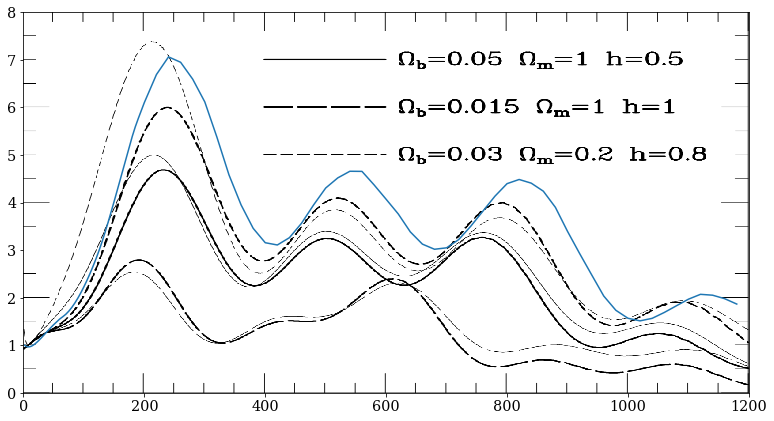

In [56]:
plt.plot(l_list,Cl*l_list*(l_list+1)/(Cl[0]*6))
plt.xlim(0,1200)


im = plt.imread('img/seljak_2.png')
implot = plt.imshow(im, extent=[0,1200,0,8],zorder=0,aspect='auto')
plt.show()